<a href="https://colab.research.google.com/github/acse-srm3018/DeeplearningProxy/blob/backup/Notebooks/Saturation_new_total_dataset_attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Saturation deep learning surrogate model  

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Sat Aug 14 14:51:19 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


## 1. Introduction


In this notebook, we demonstrate the workflow to train a surrogate deep learning model which can predict pressure and saturation using the porosity and permeability map.

Being accurate, fluid flow simulation through porous media may be really time consuming (several hours for a single run) and we have to perform hundreds of thousands of run to calibrate the models using observation data and to correctly quantifying uncertainty. / In oil industry a fast and accurate model are required for three-phase flow simulation on a 3D computational grid.

Here we will be using the deep learning platform and library Tensorflow and Keras , due to its flexibility and applications to research.

The Residual U-Net in combination with LSTM have been used as deep learning model. The modeule of this model network has been written as modeules. So, we need to upload the modules to use them.

In [5]:
from google.colab import files
files.upload()

Saving blocks.py to blocks.py
Saving unet_att.py to unet_att.py


{'blocks.py': b'"""\r\nModules for creating differnet blocks in U-net architecture.\r\n\r\nThe blocks include:\r\n\r\n1-     Convolution blocks\r\n2-     Residual blocks\r\n3-     Recurrent blocks\r\n4-     De-convolution blocks\r\n5-     Attention blocks\r\n\r\nThe sequences of these blocks then create the network for our models.\r\n"""\r\n\r\nimport tensorflow as tf\r\nfrom keras import backend as K\r\nfrom keras.engine.topology import Layer\r\nfrom keras.layers.merge import add\r\n# from keras.engine import InputSpec\r\nfrom keras.layers import InputSpec, multiply, Lambda\r\nfrom keras.layers.core import Activation\r\nfrom keras.layers.convolutional import Conv2D, UpSampling2D\r\nfrom keras.layers import BatchNormalization, Conv2DTranspose\r\nfrom keras.layers import TimeDistributed, LeakyReLU\r\nfrom keras import regularizers\r\n\r\n\r\nreg_weights = 0.00001\r\n\r\n\r\ndef conv_bn_relu(filter_num, row_num, col_num, stride):\r\n    """\r\n    Create Convolutional Batch Norm layer.\r

In [7]:
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import unet_att as vae_util_att
#import unet_uae as vae_util
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
from tensorflow.keras import layers
from tensorflow.keras.models import load_model, Model
from tensorflow.python.keras import backend as K
from keras.optimizers import Adam
import tensorflow as tf 
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.3
sess = tf.compat.v1.Session(config=config)
K.set_session(sess)

In [8]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


## 2. The dataset


First we start with loading in the dataset and evaluating its content.


### 2.1. Loading Dataset
to do this, since the data are as .npy format we need to load them using load function. 
the following function was written to load data

In [9]:
def load_data(path):
    """
    Function to load datasets in format .NPY
    
    Parameter:
    ----------
    path : string
        The absolute path of where data saved in local system
        
    Return:
    ----------
    loaded_data : ndarray
        The data which was loaded
    """
    loaded_data = np.load(path)
    return loaded_data

In [10]:
# define the absolute path of training datatsat
path_perm = '/content/gdrive/MyDrive/perm.npy'
path_sat = '/content/gdrive/MyDrive/saturation.npy'
# use load_data function nd above path to loading data
X_data= load_data(path_perm)
target_data = load_data(path_sat)

### 2.2. Preprocessing data (Normalization and standardization) 

Mean and standard deviation, Max and min of training and validation set were calcualted. Then pressure data standardized and normalized using these statistical values.

In [11]:
# Normalize data using abov normalize function
train_nr = 2250
test_nr = 750

## 3. Training the model

To train the model we defined and import the modules. Since we are dealing with encoder/decoder model we will be using loss and relative error metric as it can give better understanding of model by comparing the result from decoder with the target data. 

In [12]:
def vae_loss(x, t_decoded):
    '''Total loss for the plain UAE'''
    return K.mean(reconstruction_loss(x, t_decoded))


def reconstruction_loss(x, t_decoded):
    '''Reconstruction loss for the plain UAE'''

    return K.sum((K.batch_flatten(x) - K.batch_flatten(t_decoded)) ** 2, axis=-1)

def relative_error(x, t_decoded):
    return K.mean(K.abs(x - t_decoded) / x)

summary of model layers and parameters.

In [13]:
input_shape=(100, 100, 2)
depth = 10
#vae_model,_ = vae_util.create_vae(input_shape, depth)
vae_model_att,_ = vae_util_att.create_vae(input_shape, depth)
#vae_model.summary()

KerasTensor(type_spec=TensorSpec(shape=(None, 10, 25, 25, 1), dtype=tf.float32, name=None), name='activation_11/Sigmoid:0', description="created by layer 'activation_11'")
KerasTensor(type_spec=TensorSpec(shape=(None, 10, 25, 25, 1), dtype=tf.float32, name=None), name='activation_14/Sigmoid:0', description="created by layer 'activation_14'")
KerasTensor(type_spec=TensorSpec(shape=(None, 10, 50, 50, 1), dtype=tf.float32, name=None), name='activation_17/Sigmoid:0', description="created by layer 'activation_17'")
KerasTensor(type_spec=TensorSpec(shape=(None, 10, 50, 50, 1), dtype=tf.float32, name=None), name='activation_20/Sigmoid:0', description="created by layer 'activation_20'")
output shape is  (None, 10, 100, 100, 1)


In [14]:
depth = 10
nr = X_data.shape[0]
train_nr = 2250
test_nr = 750
train_x = np.concatenate([X_data[:train_nr,[0], ...],target_data[:train_nr,[0], ...]], axis = 1)
train_y = target_data[:train_nr, ...]

test_x = np.concatenate([X_data[nr-test_nr:,[0], ...], target_data[nr-test_nr:, [0], ...]], axis = 1)
test_y = target_data[nr-test_nr:,...]


train_x = train_x.transpose(0,2,3,1)
train_y = train_y[:,:,:,:,None]
test_x = test_x.transpose(0,2,3,1)
test_y = test_y[:,:,:,:,None]
#test_y = test_y.transpose(0,2,3,1)
print('train_x shape is ', train_x.shape)
print('train_y shape is ', train_y.shape)
print('test_x shape is ', test_x.shape)
print('test_y shape is ', test_y.shape)


train_x shape is  (2250, 100, 100, 2)
train_y shape is  (2250, 10, 100, 100, 1)
test_x shape is  (750, 100, 100, 2)
test_y shape is  (750, 10, 100, 100, 1)


In [15]:
output_dir = '/content/gdrive/MyDrive/Colab Notebooks/saved_models/'
epochs = 300
batch_size = 8
num_batch = int(train_nr/batch_size) 

In [16]:
opt = Adam(learning_rate=1e-4)
vae_model_att.compile(loss = vae_loss, optimizer = opt, metrics = [relative_error])

In [17]:
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
lrScheduler = ReduceLROnPlateau(monitor = 'loss', factor = 0.5, patience = 15, cooldown = 1, verbose = 1, min_lr = 1e-6)
filePath = 'saved-model-{epoch:03d}-{val_loss:.2f}.h5'
checkPoint = ModelCheckpoint(filePath, monitor = 'val_loss', verbose = 1, save_best_only = False, \
                             save_weights_only = True, mode = 'auto', save_freq = 20)

callbacks_list = [lrScheduler, checkPoint]

In [18]:
history = vae_model_att.fit(train_x, train_y, batch_size = batch_size, epochs = epochs, \
                        verbose = 1, validation_data = (test_x, test_y))

Epoch 1/300
282/282 [==============================] - 111s 196ms/step - loss: 10172.7010 - relative_error: 0.3979 - val_loss: 820.0652 - val_relative_error: 0.1619
Epoch 2/300
282/282 [==============================] - 50s 176ms/step - loss: 777.1031 - relative_error: 0.1523 - val_loss: 663.6003 - val_relative_error: 0.1427
Epoch 3/300
282/282 [==============================] - 50s 177ms/step - loss: 577.5692 - relative_error: 0.1307 - val_loss: 540.2399 - val_relative_error: 0.1266
Epoch 4/300
282/282 [==============================] - 50s 176ms/step - loss: 499.6321 - relative_error: 0.1216 - val_loss: 494.1592 - val_relative_error: 0.1232
Epoch 5/300
282/282 [==============================] - 50s 176ms/step - loss: 427.7037 - relative_error: 0.1123 - val_loss: 599.9590 - val_relative_error: 0.1460
Epoch 6/300
282/282 [==============================] - 49s 176ms/step - loss: 273.3663 - relative_error: 0.0822 - val_loss: 279.9959 - val_relative_error: 0.0876
Epoch 7/300
282/282 [====

In [19]:
vae_model_att.save('/content/gdrive/MyDrive/saved_models/Saturation_10_points_attention.h5')


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [20]:
vae_model_att.save('/content/gdrive/MyDrive/Saturation_10_points_attention.h5.h5')

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


dict_keys(['loss', 'relative_error', 'val_loss', 'val_relative_error'])


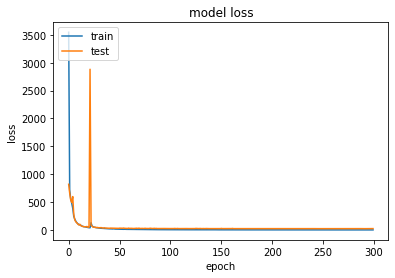

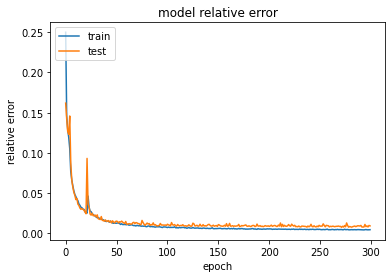

In [21]:
import matplotlib.pyplot as plt
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(np.abs(history.history['relative_error']))
plt.plot(np.abs(history.history['val_relative_error']))
plt.title('model relative error')
plt.ylabel('relative error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
#plt.save('/content/gdrive/MyDrive/Gridsearch_images/attention_pressure_train_lr5e-4_batch4_adam.png')

## 4. Hyperparameters Tuning

To optimise the model, a hyperparameter tuning step is done. The hyper- parameters are of different origins. Both the neural network and some other helper algorithms have hyperparameters to be tuned. For this operation, the training set can be divided further between the new training set and the validation set as described in the data pre-processing step. Performing Gridsearch is planned. 

## 5. Evaluation the model

With the final model trained to a great accuracy and minimum loss we need to evaluate the performance of the model. Since we do not have access to the labels of the test data, we will use a version that is only trained on 80 % of the data.

In [ ]:
vae_model.load_weights('/content/gdrive/MyDrive/saved_models/pressure_10_points_attentionunet_1e-4batch8.h5')
vae_model_att.load_weights('/content/gdrive/MyDrive/saved_models/pressure_10_points_attentionunet_1e-4batch8.h5')

In [ ]:
p_pred_list = []
test_batch_size = 50 
batch_num = int(test_nr / test_batch_size)
for i in range(batch_num):
    pred = vae_model.predict(test_x[i*test_batch_size: (i+1)*test_batch_size, ...])
    p_pred_list.append(pred[:, :, :, :, 0])

p_pred = np.concatenate(p_pred_list, axis = 0)

print(p_pred.shape)

(750, 10, 100, 100)


In [ ]:
p_true = test_y[:,:,:,:,0]
print(p_true.shape)

(750, 10, 100, 100)


In [ ]:
# convert pressure back to correct range
p_true = ((max_p - min_p) * (p_true)+ min_p)  + p_t_mean[:,:, ...]
p_pred = ((max_p - min_p) * (p_pred) + min_p) + p_t_mean[:,:, ...]
print(p_pred.shape)

(750, 10, 100, 100)


In [ ]:
p_true = p_true.transpose(0,2,3,1)
p_pred = p_pred.transpose(0,2,3,1)
print(p_true.shape)
print(p_pred.shape)

(750, 100, 100, 10)
(750, 100, 100, 10)


In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.set_cmap('jet')

ind_case = [100]
num_case = len(ind_case)

<Figure size 432x288 with 0 Axes>

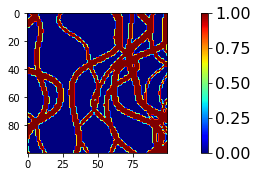

In [ ]:
for k in ind_case:
    for i_tstep in range(1):
        plt.figure(figsize=(10,7))
        # True permeability
        plt.subplot(3, 1, 1)
        plt.imshow(test_x[k, ::-1, :, 0])
        cbar = plt.colorbar(fraction=0.046)
        cbar.ax.tick_params(labelsize=16)

        plt.tight_layout()
        # plt.subplot(3, 1, 2)
        # plt.imshow(test_x[k, ::-1, :, 0].reshape((100,100)), vmin=-0.09, vmax=1.07)
        # #plt.set_clim([-0.09, 1.07])
        # cbar = plt.colorbar(fraction=0.046)
        # cbar.ax.tick_params(labelsize=16)
        # plt.tight_layout()
        # # The difference between True permeability after prediction
        # plt.subplot(3, 1, 3)
        # plt.imshow(test_x[k, ::-1, :, 0].reshape((100,100)) - test_x[k, ::-1, :, i_tstep])
        # cbar = plt.colorbar(fraction=0.046)
        # cbar.ax.tick_params(labelsize=16)
        # #plt.clim([-0.2, 0.2])
        # plt.tight_layout()
        #plt.savefig('ind_case_%d_logk'%(k),bbox_inches='tight')
plt.show()

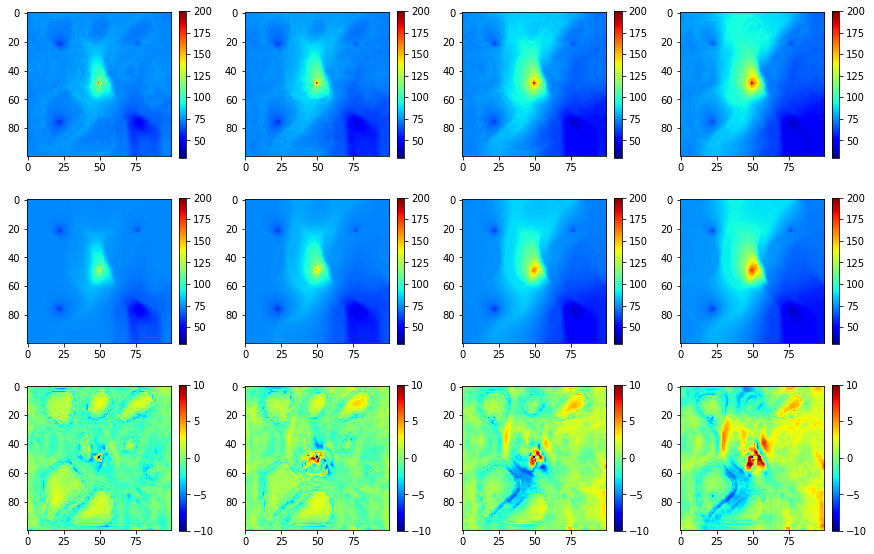

In [ ]:
for k in ind_case:
    plt.figure(figsize=(30,8))
    tstep = [0,3,6,9]
    for i_tstep in range(len(tstep)):
        plt.subplot(3, depth, i_tstep+1)
       
        plt.imshow(p_pred[k, i_tstep, :, :],  vmin = 30, vmax = 200)
        plt.colorbar(fraction=0.046)
        plt.subplot(3, depth, i_tstep+1+depth)
        plt.imshow(p_true[k, i_tstep, :, :].reshape((100,100)), vmin = 30, vmax = 200)
        plt.colorbar(fraction=0.046)
        
        plt.subplot(3, depth, i_tstep+1+2*depth)
        plt.imshow(p_true[k, i_tstep, :, :].reshape((100,100)) - p_pred[k, i_tstep, :, :], vmin = -10, vmax = 10)
        plt.colorbar(fraction=0.046)
        #plt.clim([-0.2, 0.2])
        plt.tight_layout()

plt.show()

In [ ]:
p_relative_error_time = np.mean(np.abs(p_true - p_pred) / (np.max(p_true, axis = (1, 2), keepdims =True) - np.min(p_true, axis = (1, 2), keepdims =True)), axis = (0, 1, 2))

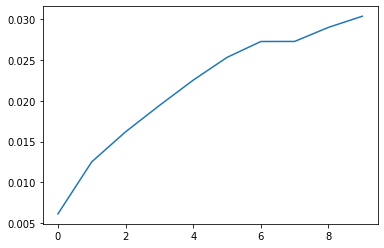

In [ ]:
plt.figure()
plt.plot(p_relative_error_time)
plt.show()

## 6. Conclusion

Further optimisation and improvements:

  Data augmentation was used to create more data. We could jhave applied filters to all the test samples to increse the contrast and make the prediction simpler for our model.
<br>

Averaging several models(model ensembeling) can give more robust results. Further investigations on different models could yield a more robust result.
<br>

 Hyperparameters were investigated but a more detailed study with a higher fidelity, different types of parameters and optimisers could have been done.
<br>

  More investigations must be done before it could be considered to be used in production for medical classification. These models must be put under a lot of scrutiny to verify if it is appropiate to classify cases for patients.

